In [1]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt

# Air Passengers

In [2]:
passengers = pd.read_csv('data/AirPassengers.csv')

df = pd.DataFrame()
df['ds'] = pd.to_datetime(passengers['Month'])
df['y'] = passengers['#Passengers']

df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


#### Run Prophet with defaults

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


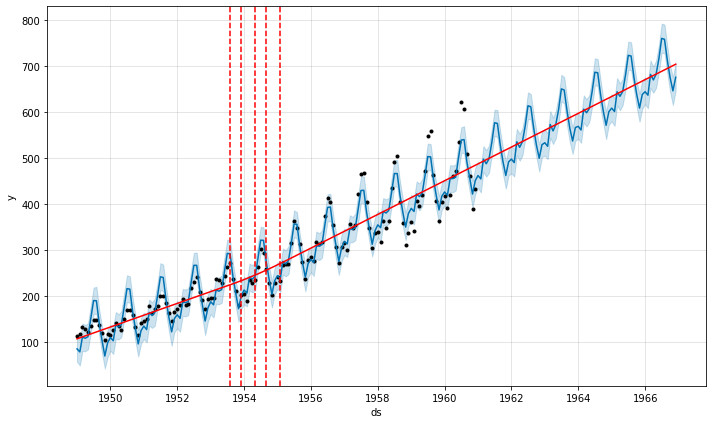

In [3]:
prophet = Prophet()
prophet.fit(df)
future = prophet.make_future_dataframe(periods=12 * 6, freq='M')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

# Divvy
### Daily

In [4]:
divvy = pd.read_csv('data/divvy_data.csv')

divvy['date'] = pd.to_datetime(divvy['starttime']).dt.date
d = divvy.groupby('date')['events'].agg({lambda x: x.value_counts().index[0]})
d['rides'] = divvy.groupby('date')['starttime'].count()
d['temperature'] = divvy.groupby('date')['temperature'].mean()
d.rename(columns={'<lambda>': 'weather'}, inplace=True)
d.reset_index(level=0, inplace=True)

d.head()

,date,weather,rides,temperature
0,2014-01-01,rain or snow,95,19.483158
1,2014-01-02,rain or snow,111,16.833333
2,2014-01-03,cloudy,6,-5.633333
3,2014-01-04,rain or snow,181,30.007735
4,2014-01-05,rain or snow,32,16.756250


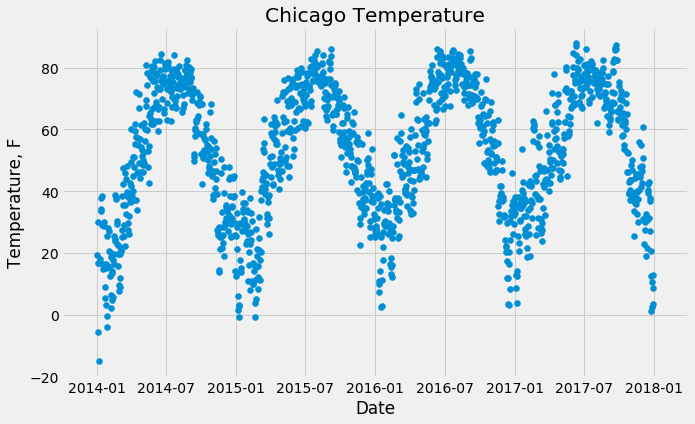

In [5]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(10, 6))
    plt.scatter(x=d['date'], y=d['temperature'])
    plt.title('Chicago Temperature')
    plt.xlabel('Date')
    plt.ylabel('Temperature, F')
    plt.show()

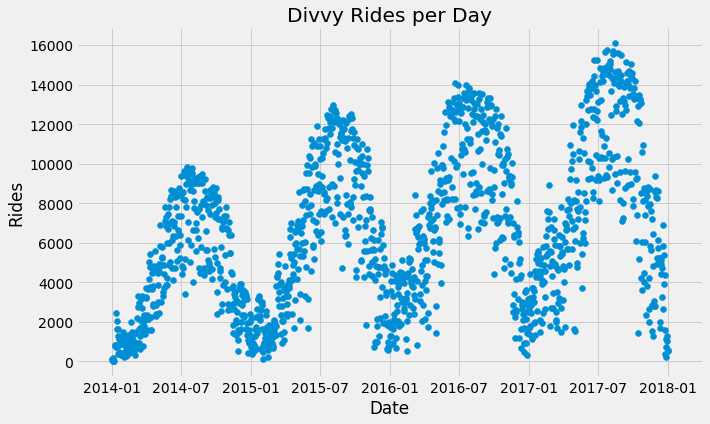

In [6]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(10, 6))
    plt.scatter(x=d['date'], y=d['rides'])
    plt.title('Divvy Rides per Day')
    plt.xlabel('Date')
    plt.ylabel('Rides')
    plt.show()

In [7]:
df = pd.DataFrame()
df['ds'] = d['date']
df['y'] = d['rides']
df['temp'] = d['temperature']
df = pd.concat([df, pd.get_dummies(d['weather'], drop_first=True)], axis=1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


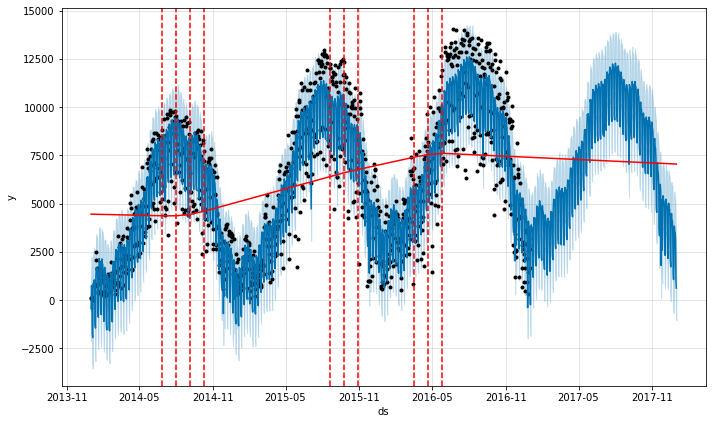

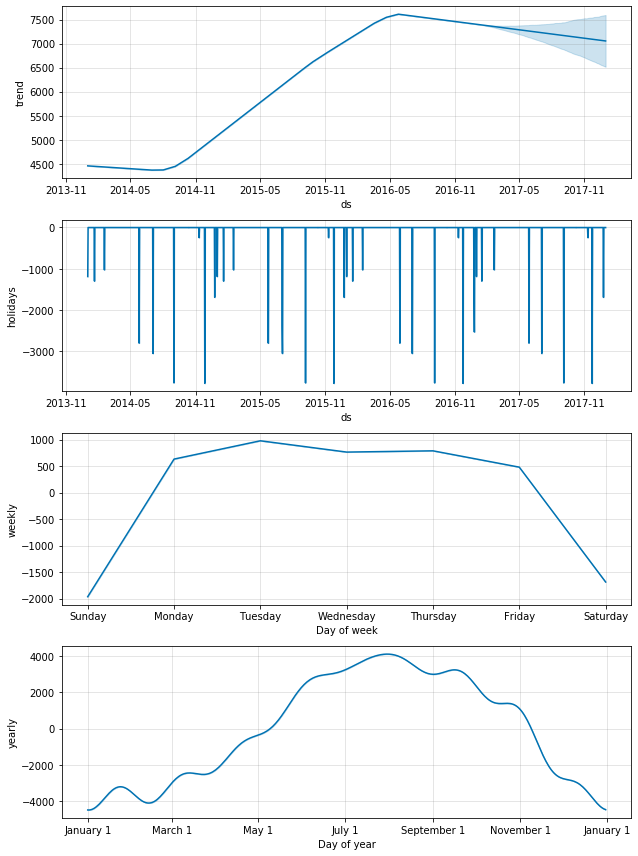

In [8]:
prophet = Prophet()
prophet.add_country_holidays(country_name='US')
prophet.fit(df[d['date'] < pd.to_datetime('2017-01-01')])
future = prophet.make_future_dataframe(periods=365, freq='d')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

#### Reduce variability of yearly seasonality

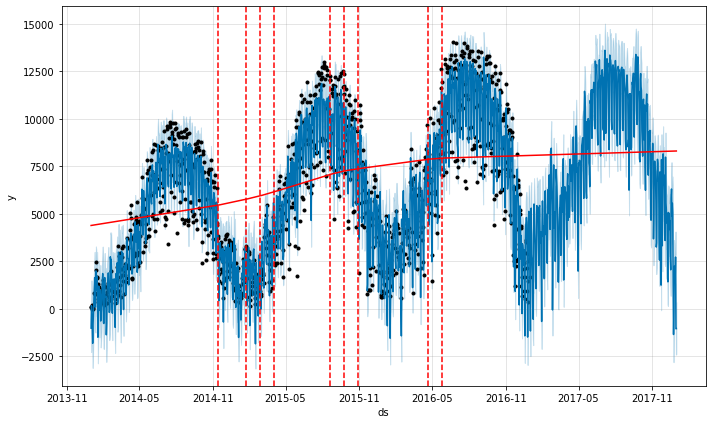

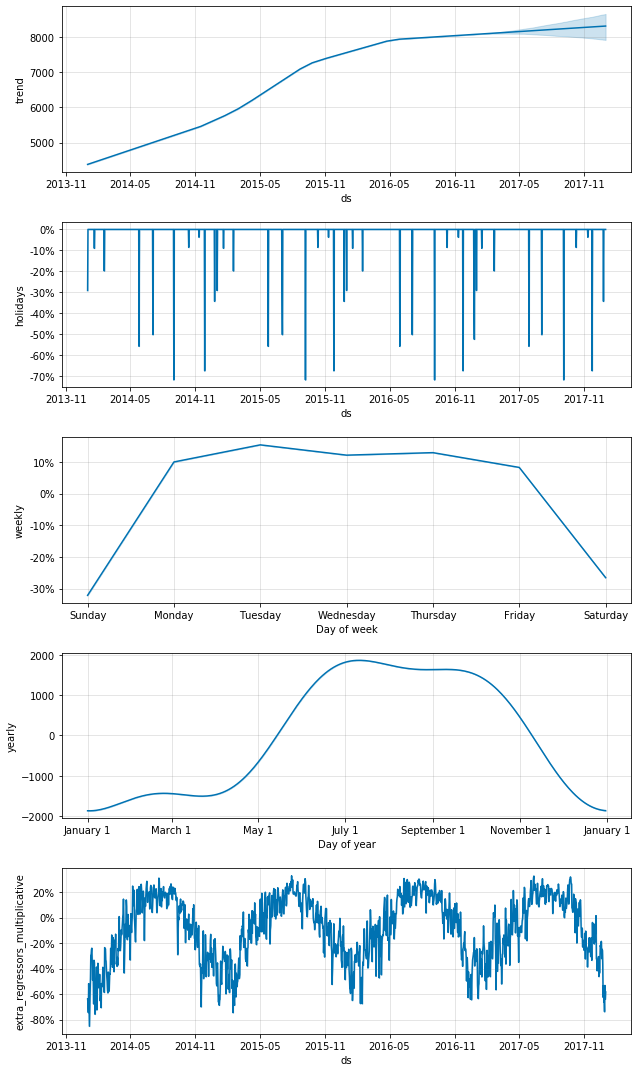

In [9]:
prophet = Prophet(growth='linear',
                  yearly_seasonality=False,
                  weekly_seasonality=True,
                  daily_seasonality=False,
                  holidays=None,
                  seasonality_mode='multiplicative',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=.05,
                  mcmc_samples=0
                 ).add_seasonality(name='yearly',
                                    period=365.25,
                                    fourier_order=3,
                                    prior_scale=10,
                                    mode='additive')

prophet.add_country_holidays(country_name='US')
prophet.add_regressor('temp')
prophet.add_regressor('cloudy')
prophet.add_regressor('not clear')
prophet.add_regressor('rain or snow')
prophet.fit(df[df['ds'] < pd.to_datetime('2017')])
future = prophet.make_future_dataframe(periods=365, freq='D')
future['temp'] = df['temp']
future['cloudy'] = df['cloudy']
future['not clear'] = df['not clear']
future['rain or snow'] = df['rain or snow']
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

#### Inspect effect of just "rain or snow" on the trend

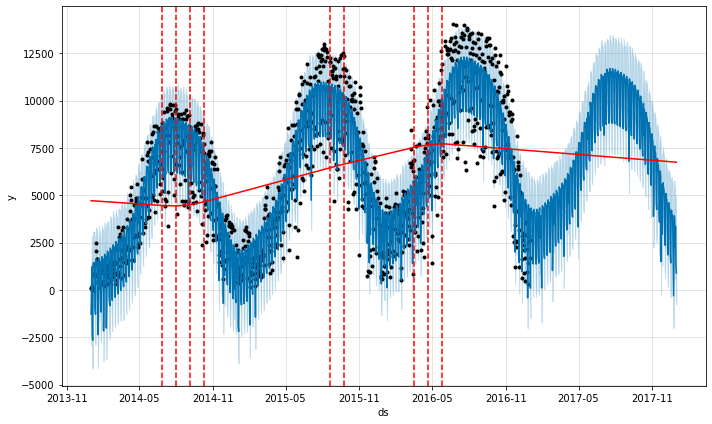

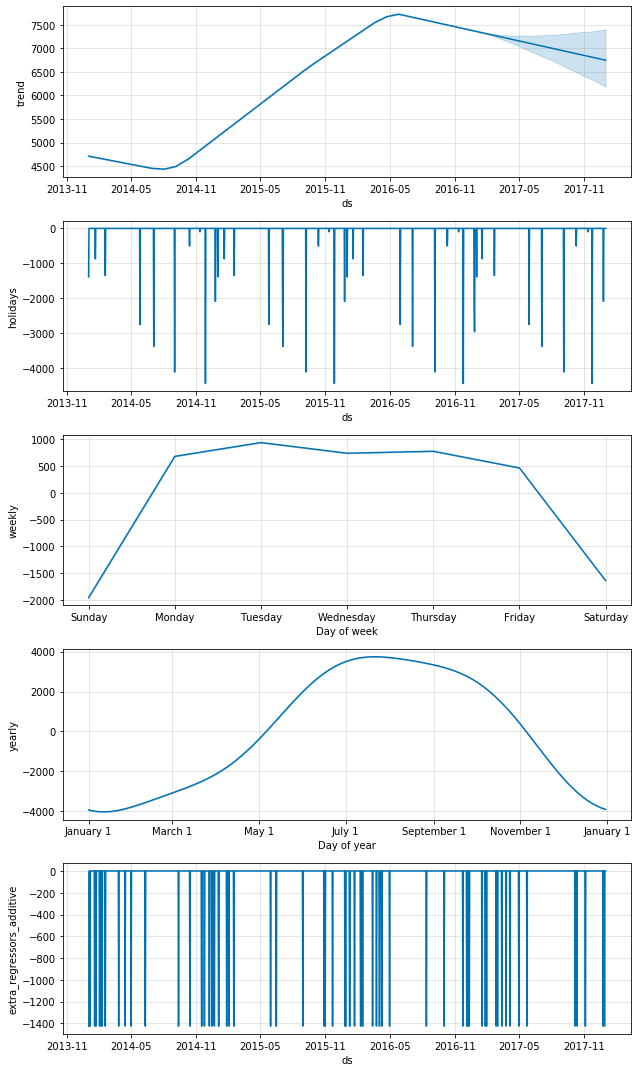

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-01-01 00:00:00 and 2016-01-01 00:00:00


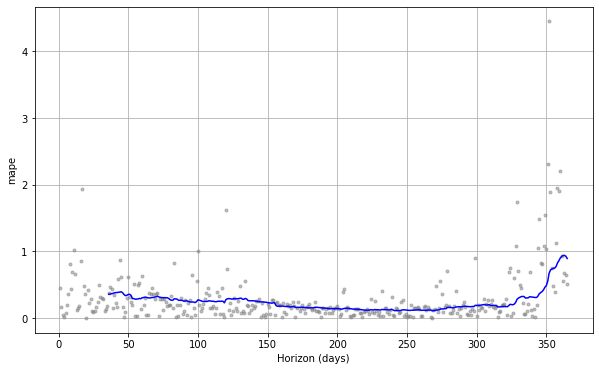

mape: 24.15%


In [10]:
prophet = Prophet(growth='linear',
                  yearly_seasonality=False,
                  weekly_seasonality=True,
                  daily_seasonality=False,
                  holidays=None,
                  seasonality_mode='additive',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=.05,
                  mcmc_samples=0
                 ).add_seasonality(name='yearly',
                                    period=365.25,
                                    fourier_order=3,
                                    prior_scale=10,
                                    mode='additive'
                  )
prophet.add_country_holidays(country_name='US')

prophet.add_regressor('rain or snow')

prophet.fit(df[df['ds'] < pd.to_datetime('2017')])
future = prophet.make_future_dataframe(periods=365, freq='D')

future['rain or snow'] = df['rain or snow']

forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()
df_cv = cross_validation(prophet, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
print('mape:', '{:.2f}%'.format(100 * df_p['mape'].mean()))

### Hourly

In [11]:
divvy['date'] = pd.to_datetime(divvy['starttime']).dt.round('H')
d = divvy.groupby('date')['events'].agg({lambda x: x.value_counts().index[0]})
d['rides'] = divvy.groupby('date')['starttime'].count()
d['temperature'] = divvy.groupby('date')['temperature'].mean()
d.rename(columns={'<lambda>': 'weather'}, inplace=True)
d.reset_index(level=0, inplace=True)

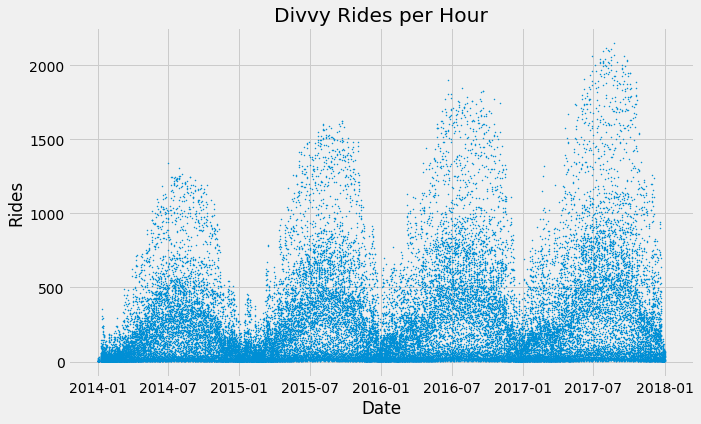

In [12]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(10, 6))
    plt.scatter(x=d['date'], y=d['rides'], s=1)
    plt.title('Divvy Rides per Hour')
    plt.xlabel('Date')
    plt.ylabel('Rides')
    plt.show()

In [13]:
df = pd.DataFrame()
df['ds'] = d['date']
df['y'] = d['rides']
df['temp'] = d['temperature']
df = pd.concat([df, pd.get_dummies(d['weather'], drop_first=True)], axis=1)

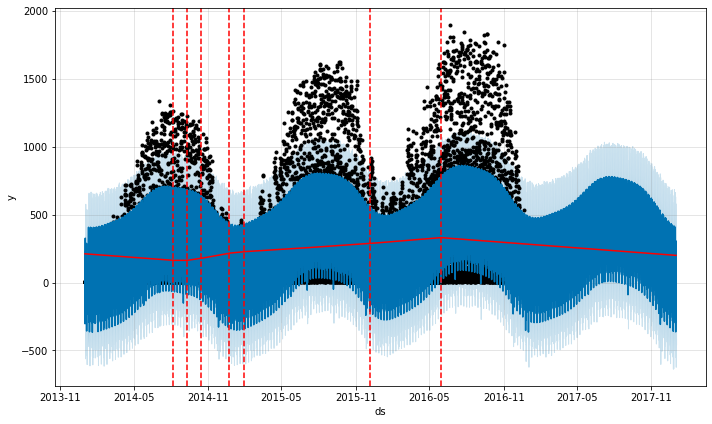

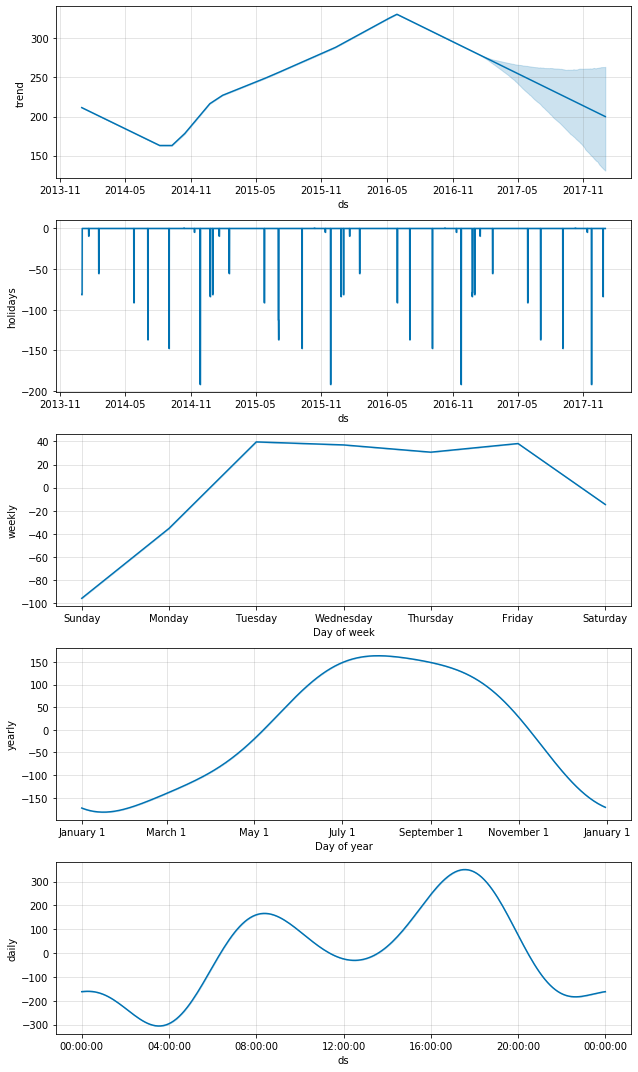

In [14]:
prophet = Prophet(yearly_seasonality=False,
                  daily_seasonality=True,
                  seasonality_mode='additive',
                  changepoint_prior_scale=.05
                 ).add_seasonality(name='yearly',
                                   period=365.25,
                                   fourier_order=3,
                                   prior_scale=10,
                                   mode='additive')

prophet.add_country_holidays(country_name='US')
prophet.fit(df[df['ds'] < pd.to_datetime('2017')])
future = prophet.make_future_dataframe(periods=365 * 24, freq='H')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

# Instagram
### natgeo

In [15]:
natgeo = pd.read_csv('data/natgeo_2019-11-21.csv')

df = pd.DataFrame()
df['ds'] = pd.to_datetime(natgeo['created_time'])
df['y'] = natgeo['likes']

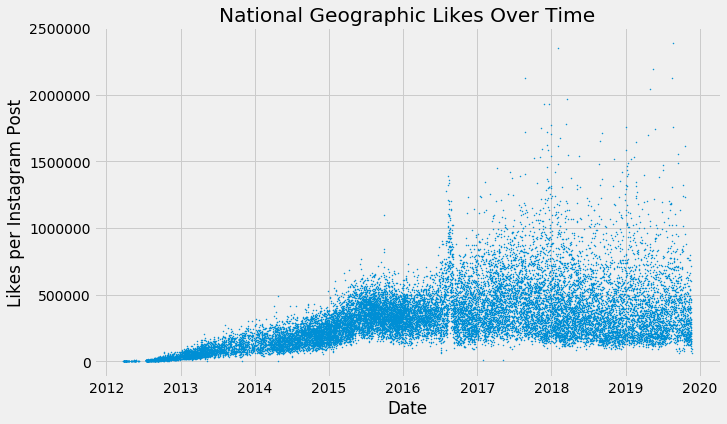

In [16]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(10, 6))
    plt.scatter(x=df['ds'], y=df['y'], s=1)
    plt.title('National Geographic Likes Over Time')
    plt.xlabel('Date')
    plt.ylabel('Likes per Instagram Post')
    plt.show()

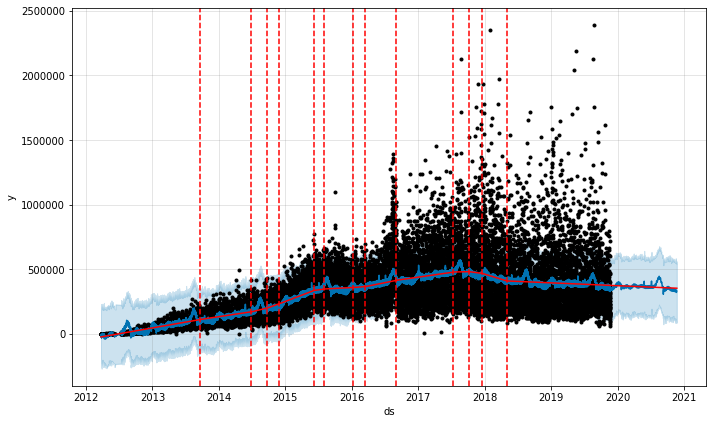

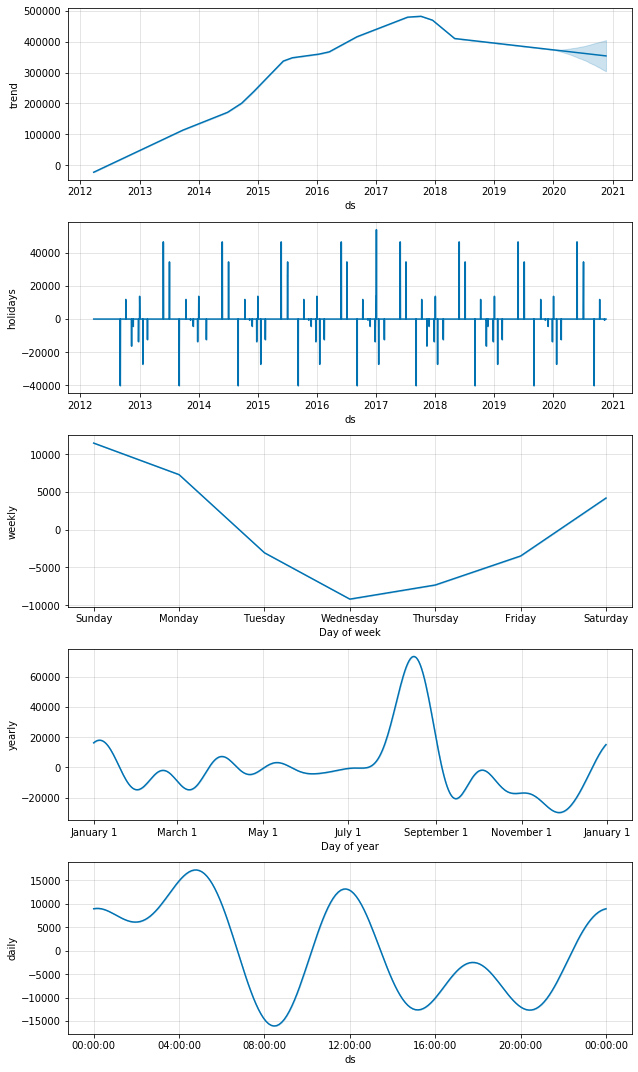

In [17]:
prophet = Prophet()
prophet.add_country_holidays(country_name='US')
prophet.fit(df)
future = prophet.make_future_dataframe(periods=365, freq='D')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

#### Add promotional marketing "holiday" events

In [18]:
#dataframe of promotional marketing events 

promo = pd.DataFrame({'holiday': "Promo event",
                      'ds' : pd.to_datetime(['2016-08-01']),
                      'lower_window': 0,
                      'upper_window': 31})
future_promo = pd.DataFrame({'holiday': "Promo event",
                      'ds' : pd.to_datetime(['2020-08-01']),
                      'lower_window': 0,
                      'upper_window': 31})

promos_hypothetical = pd.concat([promo, future_promo])

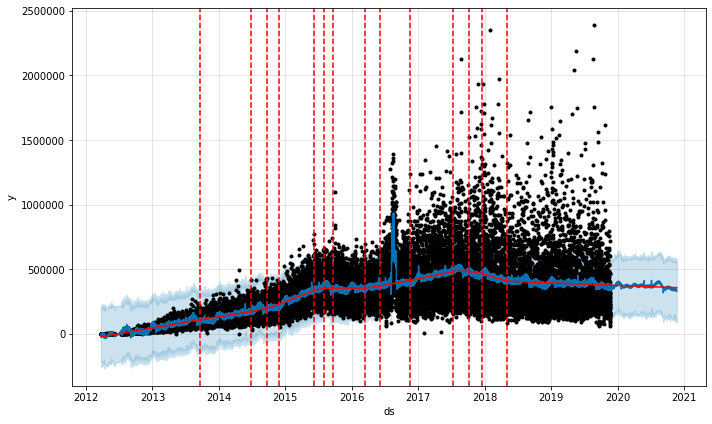

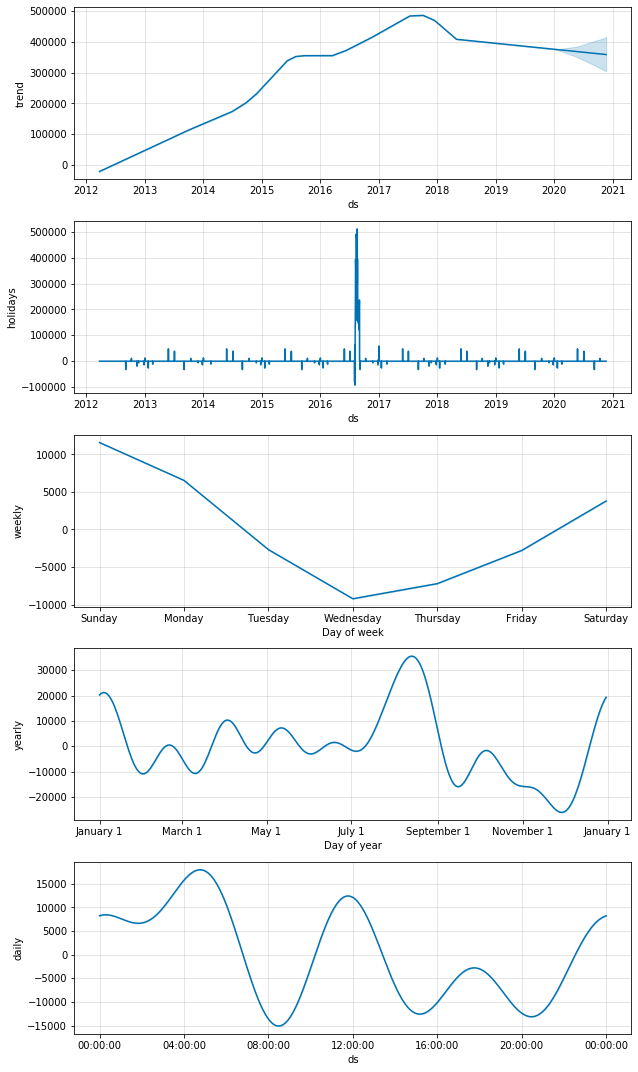

In [19]:
prophet = Prophet(holidays=promo)
prophet.add_country_holidays(country_name='US')
prophet.fit(df)
future = prophet.make_future_dataframe(periods=365, freq='D')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

#### Forecast a new promotional event

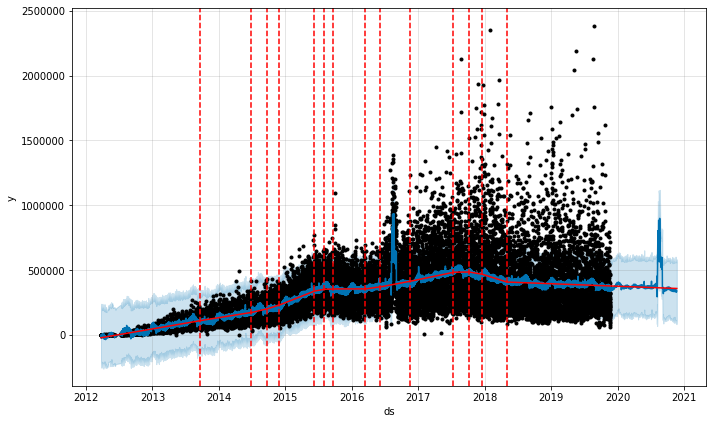

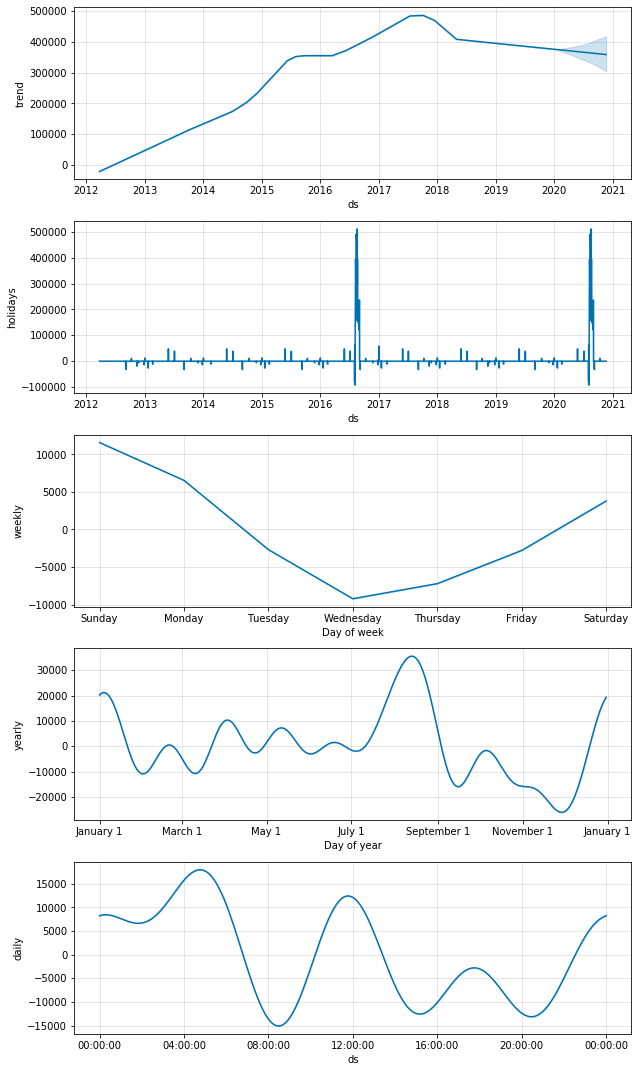

In [20]:
prophet = Prophet(holidays=promos_hypothetical)
prophet.add_country_holidays(country_name='US')
prophet.fit(df)
future = prophet.make_future_dataframe(periods=365, freq='D')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

### Anastasia Kosh

In [21]:
kosh = pd.read_csv('data/kosh_dp_2019-11-21.csv')

df = pd.DataFrame()
df['ds'] = pd.to_datetime(kosh['created_time'])
df['y'] = kosh['likes']

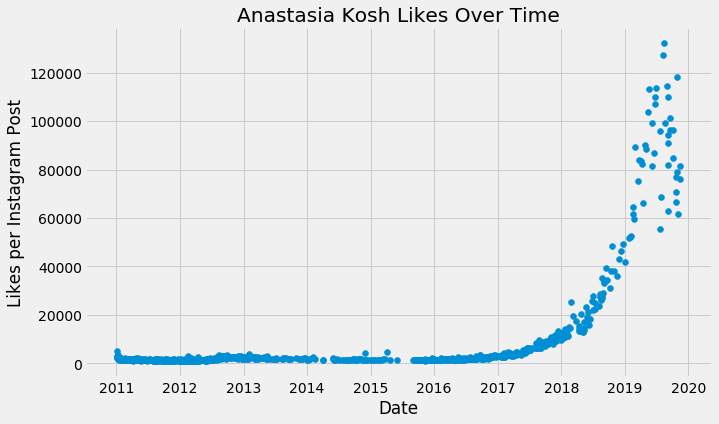

In [22]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(10, 6))
    plt.scatter(x=df['ds'], y=df['y'])
    plt.title('Anastasia Kosh Likes Over Time')
    plt.xlabel('Date')
    plt.ylabel('Likes per Instagram Post')
    plt.show()

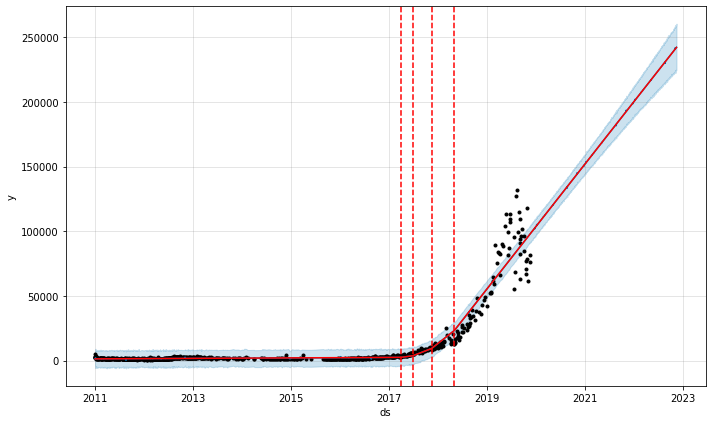

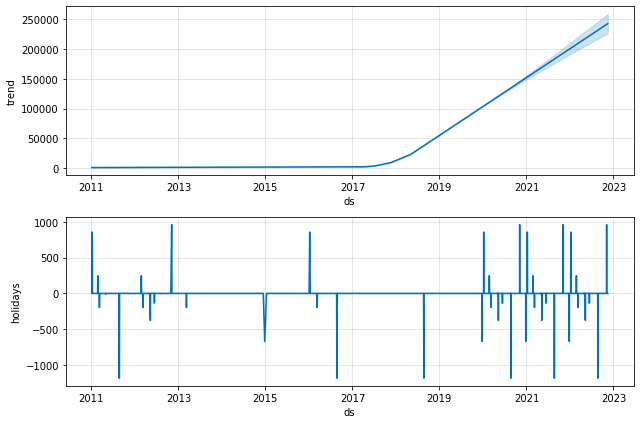

In [23]:
prophet = Prophet(growth='linear',
                  n_changepoints=25,
                  changepoint_range=0.95,
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  holidays=None,
                  seasonality_mode='additive',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=.01,
                  mcmc_samples=0)
prophet.add_country_holidays(country_name='RU')
prophet.fit(df)
future = prophet.make_future_dataframe(periods=1095, freq='D')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

#### Add a cap and floor, then model with logistic growth

In [24]:
cap = 200000
floor = 0
df['cap'] = cap
df['floor'] = floor

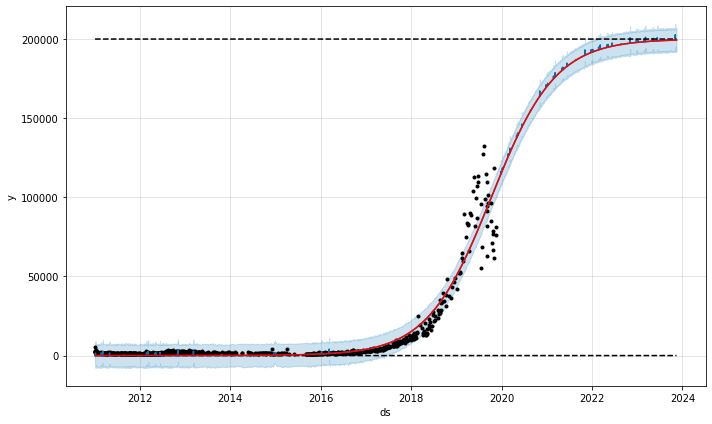

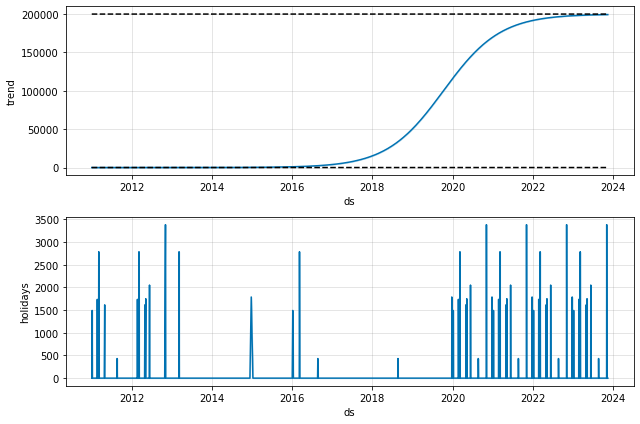

In [25]:
prophet = Prophet(growth='logistic',
                  n_changepoints=25,
                  changepoint_range=0.95,
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  holidays=None,
                  seasonality_mode='additive',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=.01,
                  mcmc_samples=0)
prophet.add_country_holidays(country_name='RU')
prophet.fit(df)
future = prophet.make_future_dataframe(periods=1460, freq='D')
future['cap'] = cap
future['floor'] = floor
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

### James Rodriguez

In [26]:
jamesrodriguez10 = pd.read_csv('data/jamesrodriguez10_2019-11-22.csv')

df = pd.DataFrame()
df['ds'] = pd.to_datetime(jamesrodriguez10['created_time'])
df['y'] = jamesrodriguez10['likes']

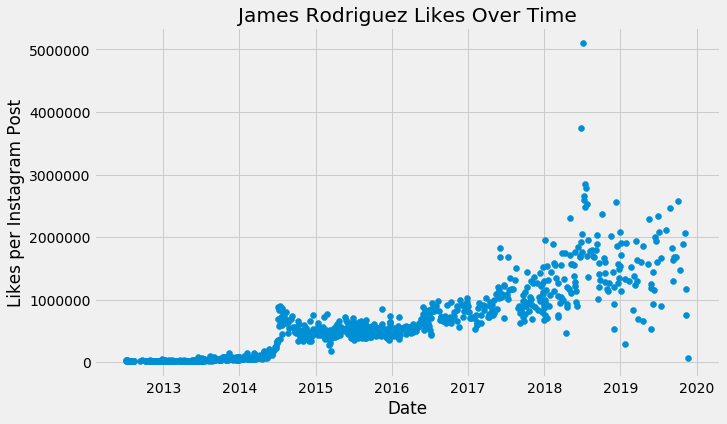

In [27]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(10, 6))
    plt.scatter(x=df['ds'], y=df['y'])
    plt.title('James Rodriguez Likes Over Time')
    plt.xlabel('Date')
    plt.ylabel('Likes per Instagram Post')
    plt.show()

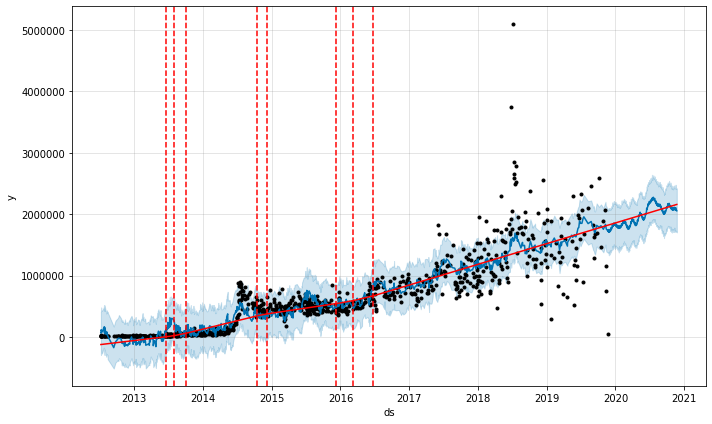

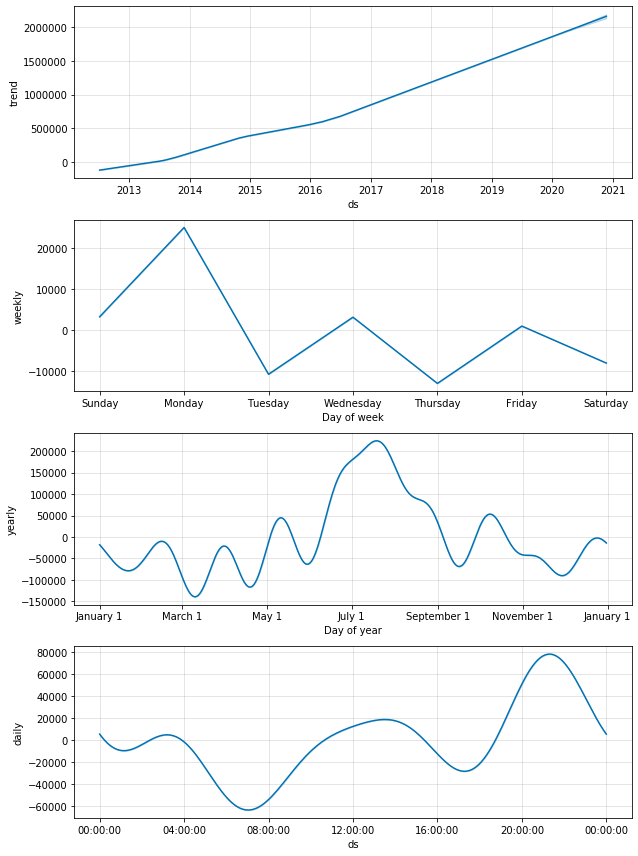

In [28]:
prophet = Prophet()
prophet.fit(df)
future = prophet.make_future_dataframe(periods=365, freq='D')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

#### Model World Cup events as holidays

In [29]:
# dataframe of World Cup events 

wc_2014 = pd.DataFrame({'holiday': "World Cup 2014",
                      'ds' : pd.to_datetime(['2014-06-12']),
                      'lower_window': 0,
                      'upper_window': 40})
wc_2018 = pd.DataFrame({'holiday': "World Cup 2018",
                      'ds' : pd.to_datetime(['2018-06-14']),
                      'lower_window': 0,
                      'upper_window': 40})

world_cup = pd.concat([wc_2014, wc_2018])

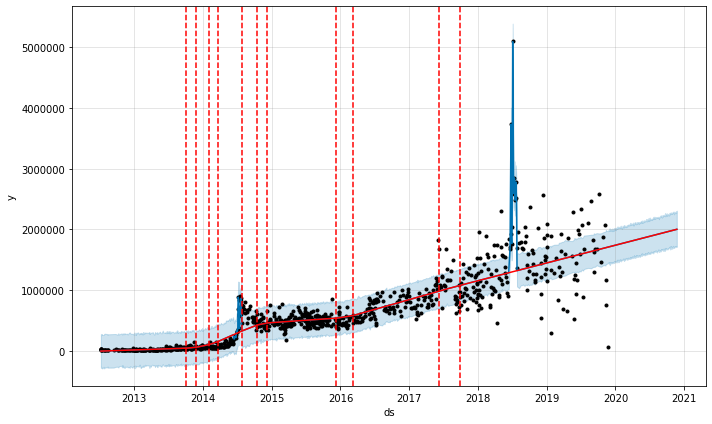

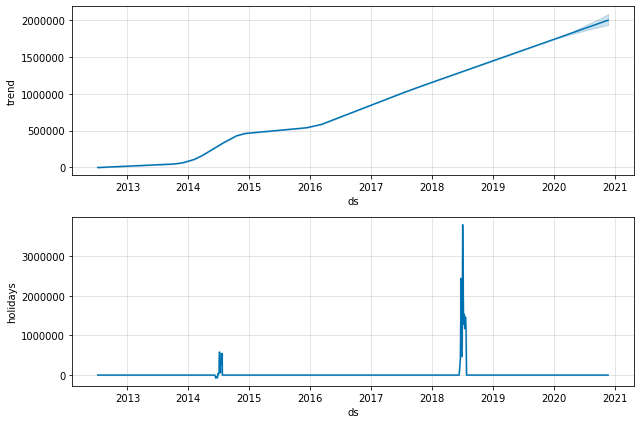

In [30]:
prophet = Prophet(yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  holidays=world_cup,
                  changepoint_prior_scale=.1)
prophet.fit(df)
future = prophet.make_future_dataframe(periods=365, freq='D')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

#### Create new regressors to indicate before, during, and after the World Cup

In [31]:
df['during_world_cup_2014'] = 0
df.loc[(df['ds'] >= pd.to_datetime('2014-05-02')) & (df['ds'] <= pd.to_datetime('2014-08-25')), 'during_world_cup_2014'] = 1
df['after_world_cup_2014'] = 0
df.loc[(df['ds'] >= pd.to_datetime('2014-08-25')), 'after_world_cup_2014'] = 1

df['during_world_cup_2018'] = 0
df.loc[(df['ds'] >= pd.to_datetime('2018-06-04')) & (df['ds'] <= pd.to_datetime('2018-07-03')), 'during_world_cup_2018'] = 1
df['after_world_cup_2018'] = 0
df.loc[(df['ds'] >= pd.to_datetime('2018-07-03')), 'after_world_cup_2018'] = 1

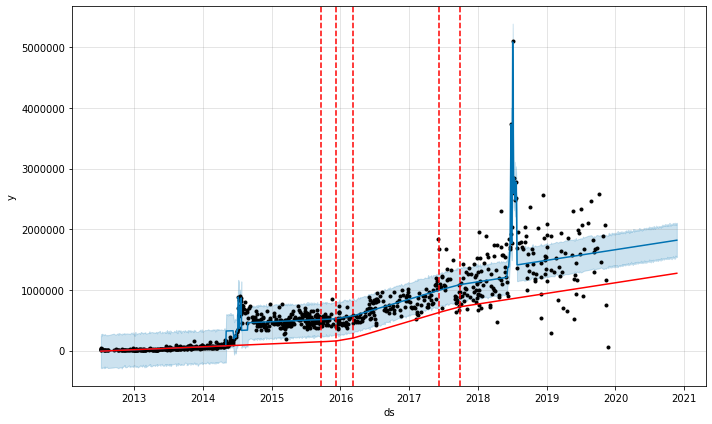

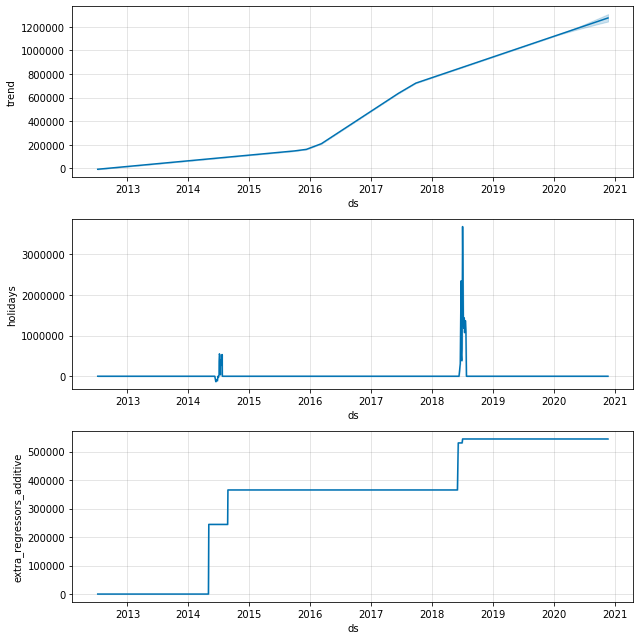

In [32]:
prophet = Prophet(yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  holidays=world_cup,
                  changepoint_prior_scale=.1)

prophet.add_regressor('during_world_cup_2014', mode='additive')
prophet.add_regressor('after_world_cup_2014', mode='additive')
prophet.add_regressor('during_world_cup_2018', mode='additive')
prophet.add_regressor('after_world_cup_2018', mode='additive')

prophet.fit(df)
future = prophet.make_future_dataframe(periods=365)

future['during_world_cup_2014'] = 0
future.loc[(future['ds'] >= pd.to_datetime('2014-05-02')) & (future['ds'] <= pd.to_datetime('2014-08-25')), 'during_world_cup_2014'] = 1
future['after_world_cup_2014'] = 0
future.loc[(future['ds'] >= pd.to_datetime('2014-08-25')), 'after_world_cup_2014'] = 1

future['during_world_cup_2018'] = 0
future.loc[(future['ds'] >= pd.to_datetime('2018-06-04')) & (future['ds'] <= pd.to_datetime('2018-07-03')), 'during_world_cup_2018'] = 1
future['after_world_cup_2018'] = 0
future.loc[(future['ds'] >= pd.to_datetime('2018-07-03')), 'after_world_cup_2018'] = 1

forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()